# Multi-label text classification

**Author:** [Farrokh Karimi](https://farrokhkarimi.github.io/)

**Editor:** [Arya Koureshi](https://aryakoureshi.github.io/)  

**Description:** In this notebook, we want to classify the Ronash dataset into 20 category.
The author's generated model had an accuracy of 81.21% and a loss of 0.8373. I made some changes, including increasing the maximum features to 19,000 and the maximum sequence to 309. Using the tuner, I obtained the best parameters and increased the accuracy of the model to **85.17%** with a loss of **0.6419**, an improvement over the author's model. This improved model is referred to as "model2". Additionally, other models were tested and achieved an accuracy of 84%.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import gdown
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [2]:
# downloading Data from the Google Drive link
gdown.download("https://drive.google.com/uc?id=1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy")

Downloading...
From: https://drive.google.com/uc?id=1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy
To: C:\Users\aryak\Ronash_DS_Assignment.csv
100%|█████████████████████████████████████████████████████████████████████████████| 1.05M/1.05M [00:00<00:00, 1.44MB/s]


'Ronash_DS_Assignment.csv'

In [3]:
# reading the csv file as a dataframe
df = pd.read_csv('Ronash_DS_Assignment.csv')
df

,product_id,title,vendor,tags,category
0,3937721221199,Fidele Super Premium Adult Large Breed Dog Food,Fidele,"['Adult', 'Bangalore', 'Chennai', 'Chicken', '...",Animals & Pet Supplies
1,7353058033889,Foldable Pet Toys Linen Storage,Cap Point,[],Animals & Pet Supplies
2,6594773549129,Bok Dok Diaper,Pets Home,"['Brand_Pet Arabia', 'Category_Pets Home', 'Ca...",Animals & Pet Supplies
3,4802008318014,Tastybone Toy Chicken,TastyBone,[],Animals & Pet Supplies
4,1779705151539,Leather Leash Tab - Short Dog Leash,Mighty Paw,"['Leash', 'Leash Tab', 'Training']",Animals & Pet Supplies
...,...,...,...,...,...
5265,4637089464407,Candylab MOO Milk Van,Candylab,"['3 Years +', 'candylab', 'Discount Products',...",Vehicles & Parts
5266,4996632444987,"Truck - Modern Era Vehicles -- Red, White - S...",Woodland Scenics,"['HO Scale', 'ho-scale-items', 'vehicles', 'wo...",Vehicles & Parts
5267,5528541003927,Car Sticker Flags Decal American Flag Sticker for,Cyan Selene,['Other'],Vehicles & Parts
5268,1395163889730,Lazer Helmets Bayamo Pit Bull - Full Face,OPEN BOX BARGAINS,"['65061090', 'Antiscratch Pinlock Ready Visor'...",Vehicles & Parts


In [4]:
# counting the number of each label
df['category'].value_counts()

Apparel & Accessories        1000
Animals & Pet Supplies        500
Food, Beverages & Tobacco     400
Sporting Goods                400
Luggage & Bags                400
Home & Garden                 400
Health & Beauty               400
Media                         300
Toys & Games                  300
Furniture                     200
Baby & Toddler                200
Arts & Entertainment          200
Electronics                   100
Business & Industrial         100
Office Supplies               100
Vehicles & Parts              100
Hardware                       50
Cameras & Optics               50
Software                       50
Religious & Ceremonial         20
Name: category, dtype: int64

In [5]:
# counting how many indices are duplicated in each column
print(f"There are {sum(df['title'].duplicated())} duplicate title.")
print(f"There are {sum(df['vendor'].duplicated())} duplicate vendor.")
print(f"There are {sum(df['tags'].duplicated())} duplicate tags.")

There are 0 duplicate title.
There are 1256 duplicate vendor.
There are 716 duplicate tags.


In [6]:
# counting the number of Nan samples
print("number of Nan samples : " + str(df.isnull().values.sum()))

number of Nan samples : 3


There are just 3 Nan samples in the dataset so we can ignore them.

In [7]:
# the function for extracting and standardizing the sentences
def text_extraction(dfi):
  # in this function, we concatenate text feature parts of the data as a sentence
  sentence = ' '.join([dfi['title'], str(dfi['vendor']), dfi['tags']])
  # Remove punctuations
  sentence = re.sub('[^a-zA-Z0-9$.]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  # Changint to lowercase
  sentence = sentence.lower()
  return sentence

# printing 10 sample sentences
for i in range(10):
  print(text_extraction(df.iloc[i]))

fidele super premium adult large breed dog food fidele adult bangalore chennai chicken doberman dog dry foods fidele german shepherd golden retriever great dane highpriority imported labrador less than 1000 less than 2000 less than 500 mastiff orange pet nutrition 
foldable pet toys linen storage cap point 
bok dok diaper pets home brand pet arabia category pets home category small pets supplies type pet home type pet supplies 
tastybone toy chicken tastybone 
leather leash tab short dog leash mighty paw leash leash tab training 
pridebites texas guitar dog toy pride bites brand pridebites toy type plush 
burns sensitive pork potato burns 10 25 25 50 50 75 adult burns coat dog food food delivery jansale18 natural nonsale19 sensitive size 12kg size 2kg size 6kg skin 
bully sticks dog toy adog.co bully sticks dog chew toys dog toys 
kazoo tough giraffe dog toy kazoo brand kazoo june2021 kazoo material plush plush 
orgo dog biscuits fresh milk petku brand orgo category dogs dogs lifestage

In [8]:
# creating the dataset
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
dataset = pd.DataFrame(columns=['text', 'label'])
for i in range(len(df)):
  dataset = dataset.append({'text':text_extraction(df.iloc[i]), 'label':df.iloc[i]['category']}, ignore_index = True);

# creating integer labels for multiclass training
dataset['label_int'] = pd.Categorical(dataset['label']).codes

In [9]:
# extracting the names of the labels
labels_names = list(Counter(dataset['label']).keys())
labels_names

['Animals & Pet Supplies',
 'Apparel & Accessories',
 'Arts & Entertainment',
 'Baby & Toddler',
 'Business & Industrial',
 'Cameras & Optics',
 'Electronics',
 'Food, Beverages & Tobacco',
 'Furniture',
 'Hardware',
 'Health & Beauty',
 'Home & Garden',
 'Luggage & Bags',
 'Media',
 'Office Supplies',
 'Religious & Ceremonial',
 'Software',
 'Sporting Goods',
 'Toys & Games',
 'Vehicles & Parts']

In [10]:
# printing each integer label and its corresponding name label
for i, label in enumerate(labels_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Animals & Pet Supplies
Label 1 corresponds to Apparel & Accessories
Label 2 corresponds to Arts & Entertainment
Label 3 corresponds to Baby & Toddler
Label 4 corresponds to Business & Industrial
Label 5 corresponds to Cameras & Optics
Label 6 corresponds to Electronics
Label 7 corresponds to Food, Beverages & Tobacco
Label 8 corresponds to Furniture
Label 9 corresponds to Hardware
Label 10 corresponds to Health & Beauty
Label 11 corresponds to Home & Garden
Label 12 corresponds to Luggage & Bags
Label 13 corresponds to Media
Label 14 corresponds to Office Supplies
Label 15 corresponds to Religious & Ceremonial
Label 16 corresponds to Software
Label 17 corresponds to Sporting Goods
Label 18 corresponds to Toys & Games
Label 19 corresponds to Vehicles & Parts


In [11]:
# splitting dataset to train, validation, and test dataframes
train_df, test_df= train_test_split(dataset, test_size=0.2, random_state=42)
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(val_df)}")
print(f"Number of samples in test set: {len(test_df)}")

# extracting texts and labels from dataframes
train_texts = train_df['text']
train_labels = train_df['label_int']
val_texts = val_df['text']
val_labels = val_df['label_int']
test_texts = test_df['text']
test_labels = test_df['label_int']

Number of samples in training set: 4216
Number of samples in validation set: 527
Number of samples in test set: 527


In [12]:
# creating data generators with batch size 32
batch_size = 32
raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

# printing texts and labels of a batch of raw train
for text, label in raw_train_batch.take(1):
  print('Texts: {}'.format(text))
  print('labels: {}'.format(label))

Texts: [b'housie tambola game by brands with foldable reusable tickets snooplay 13 17 year olds 18 years above 251 500 8 12 year olds age no bar all time favourite below 1000 below 400 below 500 best selling board games creative games gifts customer favourites diwali family friends night family games friends family nights geek gifts for boys gifts for friends gifts for girls gifts for kids gifts for parents googleshopping nerd or geek new new collection outdoor games party accessories party essentials party freak party games party games for grown ups party games for kids premium unique new toys '
 b'foldable waterproof raised dog bed dogiti '
 b'quadrello di bufala cheese cut wrapped by igourmet category cheese cut cheeses milk type buffalo nutrition full set origin italy shipping perishable texture semi soft type stinky and washed rind wholesale cheese collection '
 b'quay vip pink navy to pink lens quay accessories new summer sunglasses '
 b'seachem multitest ammonia seachem '
 b'sma

In [13]:
# counting how many words are there in the whole texts of the dataset
num_of_words = 0
for i in dataset['text']: num_of_words += len(i.split())

print(num_of_words)

112572


There are about 112000 words in the texts.



In [14]:
# counting max sequence length and how many non-repetitive words are there in the whole texts of the dataset
l = []
max_seq_lenght = 0
for i in dataset['text']:
  length = len(i.split())
  if length > max_seq_lenght: max_seq_lenght = length
  for j in i.split():
    if j not in l: l.append(j)

print("max sequence length : " + str(max_seq_lenght))
print("number of non-repetitive words in the whole texts : " + str(len(l)))

max sequence length : 309
number of non-repetitive words in the whole texts : 18933


Maximum sequence length is 309 and There are about 19000 non-repetitive words in the whole dataset texts. So we set max word features to 10000 and sequence length to 350.

In [15]:
# setting the text vectorization layer with 10000 words and 350 sequence length
max_features = 20000
sequence_length = 310

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

'''
TextVectorization is a technique in Natural Language Processing (NLP)
used to convert raw text data into numerical vectors that can be
processed by machine learning models. It involves mapping each word or
sequence of words in the text to a numerical representation, such
as an integer or a floating-point number. This numerical representation
captures the meaning and context of the words in the text and allows the
machine learning model to process the data more efficiently.
'''

# fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
vectorize_layer.adapt(train_texts)

# defining the vectorize text function
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieving a sample from a batch of texts and labels from the train set
text_batch, label_batch = next(iter(raw_train_batch))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized text", vectorize_text(first_review, first_label))

Review tf.Tensor(b'housie tambola game by brands with foldable reusable tickets snooplay 13 17 year olds 18 years above 251 500 8 12 year olds age no bar all time favourite below 1000 below 400 below 500 best selling board games creative games gifts customer favourites diwali family friends night family games friends family nights geek gifts for boys gifts for friends gifts for girls gifts for kids gifts for parents googleshopping nerd or geek new new collection outdoor games party accessories party essentials party freak party games party games for grown ups party games for kids premium unique new toys ', shape=(), dtype=string)
Label tf.Tensor(18, shape=(), dtype=int8)
Vectorized text (<tf.Tensor: shape=(1, 310), dtype=int64, numpy=
array([[12501,  9229,   192,    23,   343,    51,  1546,  2392,  9089,
         9635,   740,  1609,   275,  2882,   372,    69,   959, 15878,
          134,   109,    89,   275,  2882,    35,    55,   381,    16,
          480,  7346,   783,   181,   783,

In [16]:
# getting corresponding word of each integer 
print("1401 ---> ",vectorize_layer.get_vocabulary()[1401])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1401 --->  heel
 313 --->  is
Vocabulary size: 16230


In [17]:
# creating train, val, and test vectorized dataset and prefetching them
train_ds = raw_train_batch.map(vectorize_text)
val_ds = raw_val_batch.map(vectorize_text)
test_ds = raw_test_batch.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
# model configuration
#embedding_dim = 100
num_of_labels = 20

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

# Define the model-building function
def build_model(hp):
    dropout_rate1 = hp.Float('dropout_rate1', min_value=0.1, max_value=0.7, step=0.05)
    dropout_rate2 = hp.Float('dropout_rate2', min_value=0.1, max_value=0.7, step=0.05)
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=256, step=8)
    
    model = keras.Sequential([
      layers.Embedding(max_features + 1, embedding_dim),
      layers.Dropout(dropout_rate1),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(dropout_rate2),
      layers.Dense(num_of_labels)])

    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model


# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='my_projects',
    project_name='mhlti_class_text_classification'
)
epochs = 500


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

tuner.search(train_ds,
             validation_data=val_ds,
             epochs=epochs,
             callbacks=[callback])

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

#model.summary()

Trial 20 Complete [00h 07m 55s]
val_accuracy: 0.8298545082410177

Best val_accuracy So Far: 0.8361796339352926
Total elapsed time: 02h 20m 21s
INFO:tensorflow:Oracle triggered exit
{'dropout_rate1': 0.5, 'dropout_rate2': 0.25, 'embedding_dim': 80}


In [21]:
embedding_dim = 80
dropout_rate1 = 0.5
dropout_rate2 = 0.25

model = keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(dropout_rate1),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(dropout_rate2),
  layers.Dense(num_of_labels)])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# training the model
epochs = 500
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=30,
                                            verbose=1)
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
132/132 [==============================] - 1s 7ms/step - loss: 2.8342 - accuracy: 0.1777 - val_loss: 2.6621 - val_accuracy: 0.2163
Epoch 2/500
132/132 [==============================] - 1s 6ms/step - loss: 2.6811 - accuracy: 0.1881 - val_loss: 2.6310 - val_accuracy: 0.2163
Epoch 3/500
132/132 [==============================] - 1s 6ms/step - loss: 2.6671 - accuracy: 0.1881 - val_loss: 2.6211 - val_accuracy: 0.2163
Epoch 4/500
132/132 [==============================] - 1s 6ms/step - loss: 2.6554 - accuracy: 0.1881 - val_loss: 2.6107 - val_accuracy: 0.2163
Epoch 5/500
132/132 [==============================] - 1s 6ms/step - loss: 2.6461 - accuracy: 0.1883 - val_loss: 2.6001 - val_accuracy: 0.2163
Epoch 6/500
132/132 [==============================] - 1s 6ms/step - loss: 2.6306 - accuracy: 0.1886 - val_loss: 2.5851 - val_accuracy: 0.2182
Epoch 7/500
132/132 [==============================] - 1s 7ms/step - loss: 2.6110 - accuracy: 0.1895 - val_loss: 2.5679 - val_accuracy: 0.2182

In [22]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

17/17 [==============================] - 0s 4ms/step - loss: 0.7043 - accuracy: 0.8273
Loss:  0.7042939066886902
Accuracy:  0.8273244500160217


In [23]:
# extracting the history of training and its keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

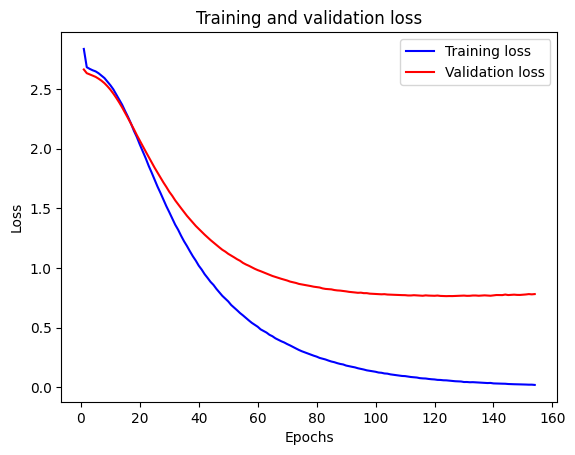

In [25]:
# ploting of loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

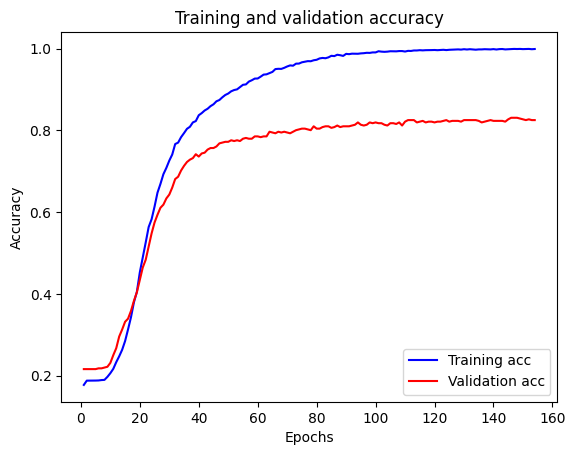

In [26]:
# plotting of accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [27]:
# creating the probability model for testing
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# predicting test samples
predictions = probability_model.predict(raw_test_batch.map(vectorize_text))

17/17 [==============================] - 0s 3ms/step


In [28]:
# showing the first test sample result label
np.argmax(predictions[0])

0

In [29]:
# showing the true label of the first test sample
test_df.iloc[0]

text         kazoo tough giraffe dog toy kazoo brand kazoo ...
label                                   Animals & Pet Supplies
label_int                                                    0
Name: 8, dtype: object

# Other Models

In [75]:
# splitting dataset to train, validation, and test dataframes
train_df, test_df= train_test_split(dataset, test_size=0.1, random_state=42)
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

# extracting texts and labels from dataframes
train_texts = train_df['text']
train_labels = train_df['label_int']
val_texts = val_df['text']
val_labels = val_df['label_int']
test_texts = test_df['text']
test_labels = test_df['label_int']

# creating data generators with batch size 128
batch_size = 128
raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

# counting how many words are there in the whole texts of the dataset
num_of_words = 0
for i in dataset['text']: num_of_words += len(i.split())

# counting max sequence length and how many non-repetitive words are there in the whole texts of the dataset
l = []
max_seq_lenght = 0
for i in dataset['text']:
  length = len(i.split())
  if length > max_seq_lenght: max_seq_lenght = length
  for j in i.split():
    if j not in l: l.append(j)

print("max sequence length : " + str(max_seq_lenght))
print("number of non-repetitive words in the whole texts : " + str(len(l)))

# setting the text vectorization layer with 10000 words and 350 sequence length
max_features = 19000
sequence_length = 309

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

'''
TextVectorization is a technique in Natural Language Processing (NLP)
used to convert raw text data into numerical vectors that can be
processed by machine learning models. It involves mapping each word or
sequence of words in the text to a numerical representation, such
as an integer or a floating-point number. This numerical representation
captures the meaning and context of the words in the text and allows the
machine learning model to process the data more efficiently.
'''

# fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
vectorize_layer.adapt(train_texts)

# defining the vectorize text function
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieving a sample from a batch of texts and labels from the train set
text_batch, label_batch = next(iter(raw_train_batch))
first_review, first_label = text_batch[0], label_batch[0]

# creating train, val, and test vectorized dataset and prefetching them
train_ds = raw_train_batch.map(vectorize_text)
val_ds = raw_val_batch.map(vectorize_text)
test_ds = raw_test_batch.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

max sequence length : 309
number of non-repetitive words in the whole texts : 18933


In [76]:
# model configuration
embedding_dim = 256
num_of_labels = 20

model1 = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.15),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(num_of_labels)])

model1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 256)         4864256   
                                                                 
 dropout_24 (Dropout)        (None, None, 256)         0         
                                                                 
 global_average_pooling1d_12  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 20)                5140      
                                                                 
Total params: 4,869,396
Trainable params: 4,869,396
Non-trainable params: 0
___________________________________________

In [77]:
# model compilation
model1.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [78]:
# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1)

history1 = model1.fit(train_ds,
                     validation_data=val_ds,
                     epochs=epochs,
                     callbacks=[callback])

Epoch 1/500
38/38 [==============================] - 1s 24ms/step - loss: 2.8795 - accuracy: 0.1463 - val_loss: 2.7661 - val_accuracy: 0.1970
Epoch 2/500
38/38 [==============================] - 1s 21ms/step - loss: 2.7079 - accuracy: 0.1895 - val_loss: 2.6703 - val_accuracy: 0.1970
Epoch 3/500
38/38 [==============================] - 1s 21ms/step - loss: 2.6669 - accuracy: 0.1895 - val_loss: 2.6490 - val_accuracy: 0.1970
Epoch 4/500
38/38 [==============================] - 1s 21ms/step - loss: 2.6528 - accuracy: 0.1895 - val_loss: 2.6380 - val_accuracy: 0.1970
Epoch 5/500
38/38 [==============================] - 1s 21ms/step - loss: 2.6422 - accuracy: 0.1900 - val_loss: 2.6283 - val_accuracy: 0.1970
Epoch 6/500
38/38 [==============================] - 1s 21ms/step - loss: 2.6290 - accuracy: 0.1900 - val_loss: 2.6178 - val_accuracy: 0.1970
Epoch 7/500
38/38 [==============================] - 1s 21ms/step - loss: 2.6135 - accuracy: 0.1902 - val_loss: 2.6050 - val_accuracy: 0.2008
Epoch 

In [80]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model1.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

3/3 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.8479
Loss:  0.6430718302726746
Accuracy:  0.8479087352752686


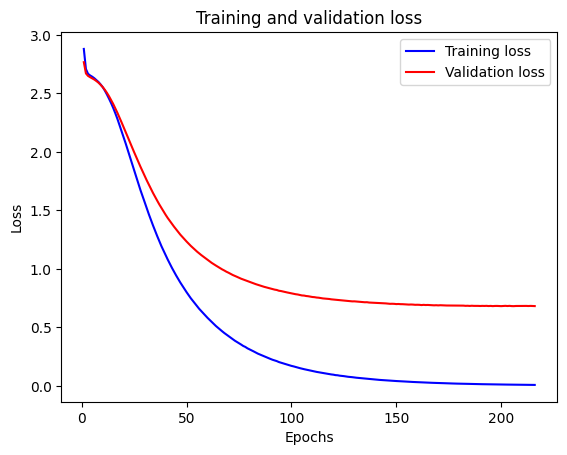

In [90]:
# extracting the history of training and its keys
history_dict = history1.history

acc1 = history_dict['accuracy']
val_acc1 = history_dict['val_accuracy']
loss1 = history_dict['loss']
val_loss1 = history_dict['val_loss']

epochs = range(1, len(acc1) + 1)

# ploting of loss
plt.plot(epochs, loss1, 'b', label='Training loss')
plt.plot(epochs, val_loss1, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

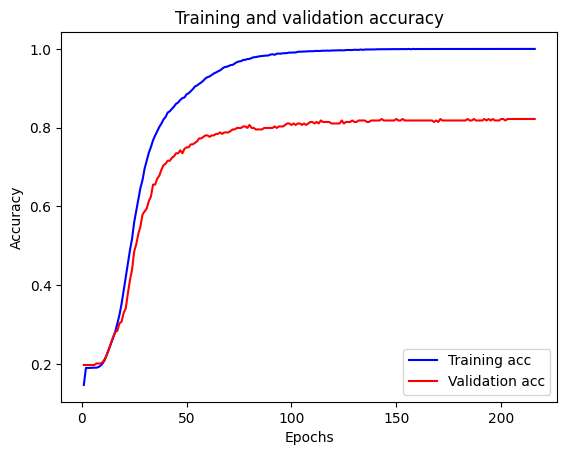

3/3 [==============================] - 0s 3ms/step


In [91]:
# plotting of accuracy
plt.plot(epochs, acc1, 'b', label='Training acc')
plt.plot(epochs, val_acc1, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# creating the probability model for testing
probability_model1 = tf.keras.Sequential([model1, tf.keras.layers.Softmax()])

# predicting test samples
predictions1 = probability_model1.predict(raw_test_batch.map(vectorize_text))

In [94]:
embedding_dim = 80
dropout_rate1 = 0.5
dropout_rate2 = 0.25

model2 = keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(dropout_rate1),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(dropout_rate2),
  layers.Dense(num_of_labels)])

optimizer = tf.keras.optimizers.Adam()
model2.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# training the model
epochs = 500
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1)
history2 = model2.fit(train_ds,
                     validation_data=val_ds,
                     epochs=epochs,
                     callbacks=[callback])

Epoch 1/500
38/38 [==============================] - 1s 12ms/step - loss: 2.9402 - accuracy: 0.1706 - val_loss: 2.8793 - val_accuracy: 0.1970
Epoch 2/500
38/38 [==============================] - 0s 9ms/step - loss: 2.8169 - accuracy: 0.1895 - val_loss: 2.7544 - val_accuracy: 0.1970
Epoch 3/500
38/38 [==============================] - 0s 10ms/step - loss: 2.7188 - accuracy: 0.1895 - val_loss: 2.6879 - val_accuracy: 0.1970
Epoch 4/500
38/38 [==============================] - 0s 10ms/step - loss: 2.6831 - accuracy: 0.1895 - val_loss: 2.6670 - val_accuracy: 0.1970
Epoch 5/500
38/38 [==============================] - 0s 9ms/step - loss: 2.6686 - accuracy: 0.1895 - val_loss: 2.6558 - val_accuracy: 0.1970
Epoch 6/500
38/38 [==============================] - 0s 9ms/step - loss: 2.6632 - accuracy: 0.1895 - val_loss: 2.6488 - val_accuracy: 0.1970
Epoch 7/500
38/38 [==============================] - 0s 9ms/step - loss: 2.6584 - accuracy: 0.1895 - val_loss: 2.6435 - val_accuracy: 0.1970
Epoch 8/50

In [95]:
loss, accuracy = model2.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

3/3 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.8517
Loss:  0.6419950127601624
Accuracy:  0.8517110347747803


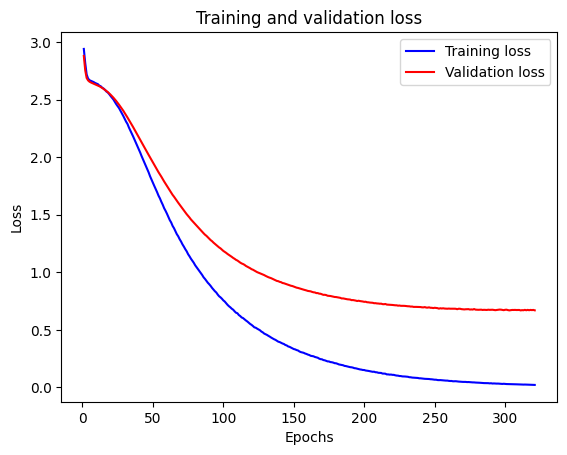

In [96]:
# extracting the history of training and its keys
history_dict2 = history2.history

acc2 = history_dict2['accuracy']
val_acc2 = history_dict2['val_accuracy']
loss2 = history_dict2['loss']
val_loss2 = history_dict2['val_loss']

epochs = range(1, len(acc2) + 1)

# ploting of loss
plt.plot(epochs, loss2, 'b', label='Training loss')
plt.plot(epochs, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

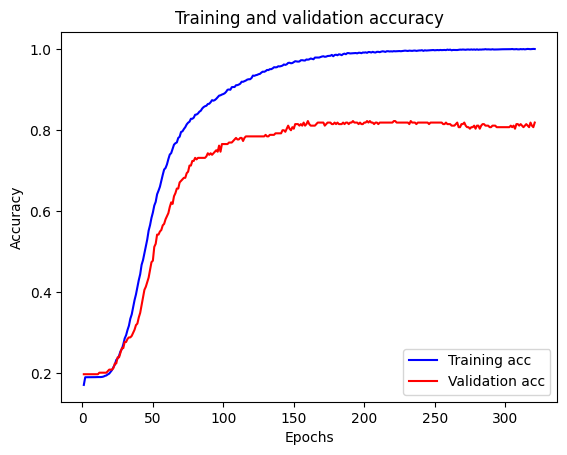

3/3 [==============================] - 0s 7ms/step


In [97]:
# plotting of accuracy
plt.plot(epochs, acc2, 'b', label='Training acc')
plt.plot(epochs, val_acc2, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# creating the probability model for testing
probability_model2 = tf.keras.Sequential([model2, tf.keras.layers.Softmax()])

# predicting test samples
predictions2 = probability_model2.predict(raw_test_batch.map(vectorize_text))

In [98]:
embedding_dim = 80


model3 = keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Bidirectional(layers.LSTM(128, return_sequences=True, )),
  layers.Bidirectional(layers.LSTM(64)),
  layers.Dense(num_of_labels)])

optimizer = tf.keras.optimizers.Adam()
model3.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# training the model
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1)
history3 = model3.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/100
38/38 [==============================] - 15s 135ms/step - loss: 2.7708 - accuracy: 0.1862 - val_loss: 2.6433 - val_accuracy: 0.1970
Epoch 2/100
38/38 [==============================] - 4s 97ms/step - loss: 2.4097 - accuracy: 0.2595 - val_loss: 2.2040 - val_accuracy: 0.2955
Epoch 3/100
38/38 [==============================] - 4s 101ms/step - loss: 1.7641 - accuracy: 0.4655 - val_loss: 1.8817 - val_accuracy: 0.4053
Epoch 4/100
38/38 [==============================] - 4s 99ms/step - loss: 1.2383 - accuracy: 0.6390 - val_loss: 1.5629 - val_accuracy: 0.5644
Epoch 5/100
38/38 [==============================] - 4s 109ms/step - loss: 0.9100 - accuracy: 0.7603 - val_loss: 1.5877 - val_accuracy: 0.5189
Epoch 6/100
38/38 [==============================] - 4s 106ms/step - loss: 0.7141 - accuracy: 0.8157 - val_loss: 1.4307 - val_accuracy: 0.6098
Epoch 7/100
38/38 [==============================] - 4s 106ms/step - loss: 0.5241 - accuracy: 0.8743 - val_loss: 1.4533 - val_accuracy: 0.6439


In [99]:
loss, accuracy = model3.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

3/3 [==============================] - 0s 44ms/step - loss: 1.3566 - accuracy: 0.6654
Loss:  1.35657799243927
Accuracy:  0.6653992533683777


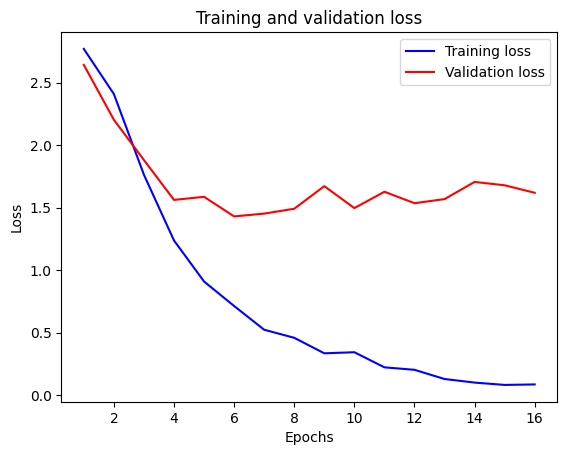

In [100]:
# extracting the history of training and its keys
history_dict3 = history3.history

acc3 = history_dict3['accuracy']
val_acc3 = history_dict3['val_accuracy']
loss3 = history_dict3['loss']
val_loss3 = history_dict3['val_loss']

epochs = range(1, len(acc3) + 1)

# ploting of loss
plt.plot(epochs, loss3, 'b', label='Training loss')
plt.plot(epochs, val_loss3, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

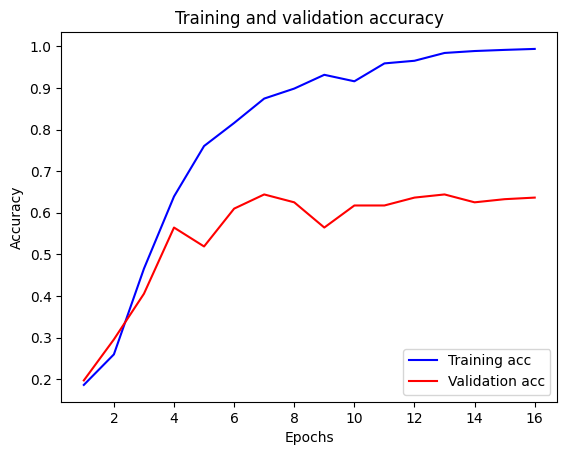

3/3 [==============================] - 2s 50ms/step


In [101]:
# plotting of accuracy
plt.plot(epochs, acc3, 'b', label='Training acc')
plt.plot(epochs, val_acc3, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# creating the probability model for testing
probability_model3 = tf.keras.Sequential([model3, tf.keras.layers.Softmax()])

# predicting test samples
predictions3 = probability_model3.predict(raw_test_batch.map(vectorize_text))

In [113]:
embedding_dim = 100

model4 = keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Conv1D(filters=512, kernel_size=5, activation='relu'),
  layers.MaxPooling1D(pool_size=4),
  layers.Bidirectional(layers.LSTM(256)),
  layers.Dropout(0.4),
  layers.Dense(num_of_labels)
])

optimizer = tf.keras.optimizers.Adam()
model4.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# training the model
epochs = 200
history4 = model4.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )])

Epoch 1/200
38/38 [==============================] - 10s 172ms/step - loss: 2.6879 - accuracy: 0.1794 - val_loss: 2.4709 - val_accuracy: 0.2311
Epoch 2/200
38/38 [==============================] - 6s 149ms/step - loss: 1.9003 - accuracy: 0.4320 - val_loss: 1.4739 - val_accuracy: 0.5530
Epoch 3/200
38/38 [==============================] - 6s 151ms/step - loss: 0.8153 - accuracy: 0.7723 - val_loss: 1.1378 - val_accuracy: 0.6856
Epoch 4/200
38/38 [==============================] - 6s 151ms/step - loss: 0.3451 - accuracy: 0.9026 - val_loss: 1.0345 - val_accuracy: 0.7159
Epoch 5/200
38/38 [==============================] - 5s 144ms/step - loss: 0.1654 - accuracy: 0.9576 - val_loss: 1.1041 - val_accuracy: 0.7348
Epoch 6/200
38/38 [==============================] - 6s 145ms/step - loss: 0.0758 - accuracy: 0.9833 - val_loss: 1.2138 - val_accuracy: 0.7311
Epoch 7/200
38/38 [==============================] - 5s 144ms/step - loss: 0.0364 - accuracy: 0.9933 - val_loss: 1.2783 - val_accuracy: 0.738

In [114]:
loss, accuracy = model4.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

3/3 [==============================] - 0s 37ms/step - loss: 0.9518 - accuracy: 0.7871
Loss:  0.9518163204193115
Accuracy:  0.7870722413063049


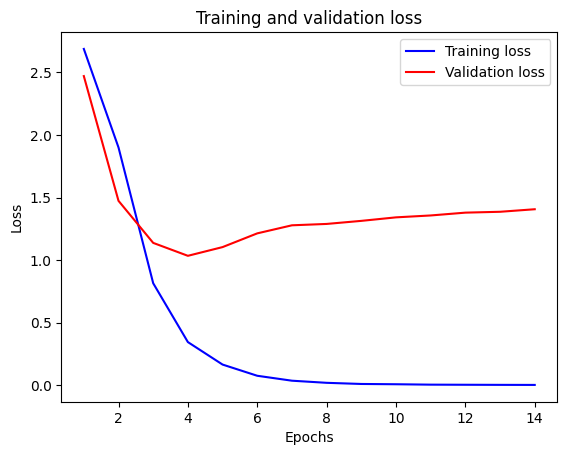

In [115]:
# extracting the history of training and its keys
history_dict4 = history4.history

acc4 = history_dict4['accuracy']
val_acc4 = history_dict4['val_accuracy']
loss4 = history_dict4['loss']
val_loss4 = history_dict4['val_loss']

epochs = range(1, len(acc4) + 1)

# ploting of loss
plt.plot(epochs, loss4, 'b', label='Training loss')
plt.plot(epochs, val_loss4, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

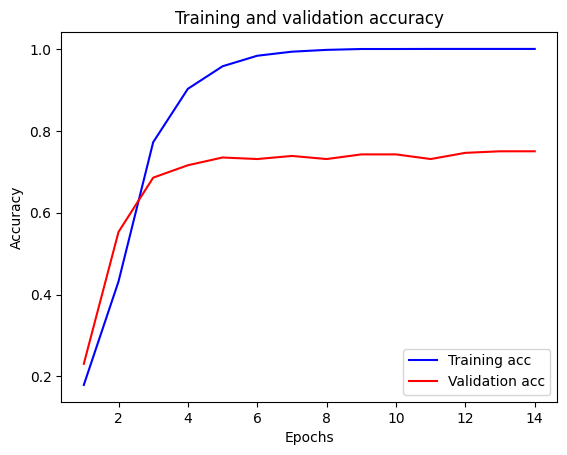

3/3 [==============================] - 1s 32ms/step


In [116]:
# plotting of accuracy
plt.plot(epochs, acc4, 'b', label='Training acc')
plt.plot(epochs, val_acc4, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# creating the probability model for testing
probability_model4 = tf.keras.Sequential([model4, tf.keras.layers.Softmax()])

# predicting test samples
predictions4 = probability_model4.predict(raw_test_batch.map(vectorize_text))

In [159]:
embedding_dim = 80
model5 = keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim, input_length=309),
  layers.Dropout(0.1),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.1),
  layers.Dense(num_of_labels)
])

optimizer = tf.keras.optimizers.Adam()
model5.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# training the model
epochs = 500
history5 = model5.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        restore_best_weights=True
                    )])


Epoch 1/500
38/38 [==============================] - 1s 14ms/step - loss: 2.9465 - accuracy: 0.1482 - val_loss: 2.8825 - val_accuracy: 0.1970
Epoch 2/500
38/38 [==============================] - 0s 10ms/step - loss: 2.8152 - accuracy: 0.1895 - val_loss: 2.7518 - val_accuracy: 0.1970
Epoch 3/500
38/38 [==============================] - 0s 10ms/step - loss: 2.7097 - accuracy: 0.1895 - val_loss: 2.6829 - val_accuracy: 0.1970
Epoch 4/500
38/38 [==============================] - 0s 10ms/step - loss: 2.6733 - accuracy: 0.1895 - val_loss: 2.6615 - val_accuracy: 0.1970
Epoch 5/500
38/38 [==============================] - 0s 10ms/step - loss: 2.6620 - accuracy: 0.1895 - val_loss: 2.6504 - val_accuracy: 0.1970
Epoch 6/500
38/38 [==============================] - 0s 10ms/step - loss: 2.6545 - accuracy: 0.1895 - val_loss: 2.6428 - val_accuracy: 0.1970
Epoch 7/500
38/38 [==============================] - 0s 10ms/step - loss: 2.6473 - accuracy: 0.1898 - val_loss: 2.6363 - val_accuracy: 0.1970
Epoch 

In [160]:
loss, accuracy = model5.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

3/3 [==============================] - 0s 6ms/step - loss: 0.6586 - accuracy: 0.8403
Loss:  0.6585977673530579
Accuracy:  0.8403041958808899


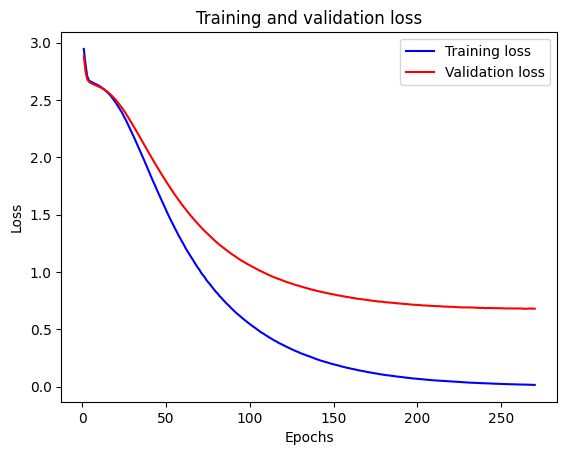

In [161]:
# extracting the history of training and its keys
history_dict5 = history5.history

acc5 = history_dict5['accuracy']
val_acc5 = history_dict5['val_accuracy']
loss5 = history_dict5['loss']
val_loss5 = history_dict5['val_loss']

epochs = range(1, len(acc5) + 1)

# ploting of loss
plt.plot(epochs, loss5, 'b', label='Training loss')
plt.plot(epochs, val_loss5, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

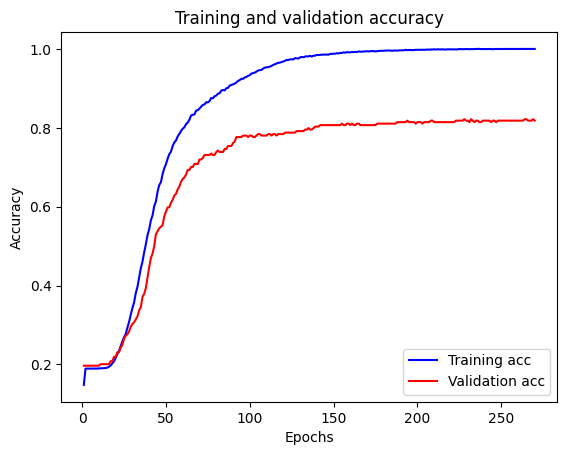

3/3 [==============================] - 0s 0s/step


In [162]:
# plotting of accuracy
plt.plot(epochs, acc5, 'b', label='Training acc')
plt.plot(epochs, val_acc5, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# creating the probability model for testing
probability_model5 = tf.keras.Sequential([model5, tf.keras.layers.Softmax()])

# predicting test samples
predictions5 = probability_model5.predict(raw_test_batch.map(vectorize_text))

**Editor:** https://aryakoureshi.github.io/